In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import scipy.optimize as so
import seaborn as sb
sb.set()

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Load historical prices

In [3]:
def load_data():
    symbols = [ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT']

    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('%s.csv' % s, index_col=None, parse_dates=['Date'])
        prices = list(dataframe['Close'])[-506:] # trailing window 506 days 2 roz bishtar vase roze aval va akhar ezafe
        prices_out.append(prices)
       
    return symbols, prices_out 

names, prices = load_data()   
n = len(names)

In [4]:
pd.DataFrame(prices)

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,500,501,502,503,504,505
0,163.050003,166.720001,169.039993,166.889999,168.110001,172.500000,174.250000,174.809998,176.240005,175.880005,...,236.410004,240.509995,239.960007,243.179993,243.580002,246.580002,249.050003,243.289993,243.259995,248.759995
1,83.809998,83.889999,83.180000,83.180000,84.050003,84.139999,84.470001,84.269997,84.559998,84.089996,...,137.410004,138.429993,136.369995,137.240005,139.940002,140.729996,144.190002,142.830002,144.610001,143.369995
2,234.740005,231.020004,230.190002,230.179993,232.229996,232.220001,230.309998,230.050003,229.830002,228.389999,...,163.100006,165.940002,167.539993,168.759995,161.889999,166.089996,169.059998,168.809998,168.369995,164.990005
3,1100.949951,1110.849976,1105.280029,1103.680054,1094.219971,1111.599976,1120.660034,1123.170044,1132.880005,1129.130005,...,1757.510010,1785.660034,1765.729980,1762.170044,1780.780029,1761.329956,1777.079956,1762.709961,1779.989990,1776.660034
4,1019.270020,1017.109985,1016.640015,1025.500000,1025.579956,1032.479980,1025.900024,1033.329956,1039.849976,1031.260010,...,1245.489990,1246.150024,1242.800049,1259.130005,1260.989990,1265.130005,1290.000000,1262.619995,1261.290039,1260.109985
5,101.769997,101.410004,100.610001,100.919998,101.589996,101.410004,100.779999,98.750000,97.639999,97.629997,...,120.559998,123.550003,124.790001,125.120003,125.029999,126.029999,126.510002,126.430000,125.730003,124.919998
6,48.740002,49.110001,49.240002,49.549999,49.590000,49.540001,49.480000,48.230000,47.750000,46.750000,...,52.669998,53.450001,53.470001,53.490002,53.049999,53.580002,54.000000,54.240002,53.680000,53.049999


## Estimate assets historical return and covariances

In [5]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calculate covariances
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 252 - 1  # Annualize returns
    covars = covars * 252  # Annualize covariances
    return expreturns, covars

In [6]:
a=matrix(prices)
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,500,501,502,503,504,505
0,163.050003,166.720001,169.039993,166.889999,168.110001,172.500000,174.250000,174.809998,176.240005,175.880005,...,236.410004,240.509995,239.960007,243.179993,243.580002,246.580002,249.050003,243.289993,243.259995,248.759995
1,83.809998,83.889999,83.180000,83.180000,84.050003,84.139999,84.470001,84.269997,84.559998,84.089996,...,137.410004,138.429993,136.369995,137.240005,139.940002,140.729996,144.190002,142.830002,144.610001,143.369995
2,234.740005,231.020004,230.190002,230.179993,232.229996,232.220001,230.309998,230.050003,229.830002,228.389999,...,163.100006,165.940002,167.539993,168.759995,161.889999,166.089996,169.059998,168.809998,168.369995,164.990005
3,1100.949951,1110.849976,1105.280029,1103.680054,1094.219971,1111.599976,1120.660034,1123.170044,1132.880005,1129.130005,...,1757.510010,1785.660034,1765.729980,1762.170044,1780.780029,1761.329956,1777.079956,1762.709961,1779.989990,1776.660034
4,1019.270020,1017.109985,1016.640015,1025.500000,1025.579956,1032.479980,1025.900024,1033.329956,1039.849976,1031.260010,...,1245.489990,1246.150024,1242.800049,1259.130005,1260.989990,1265.130005,1290.000000,1262.619995,1261.290039,1260.109985
5,101.769997,101.410004,100.610001,100.919998,101.589996,101.410004,100.779999,98.750000,97.639999,97.629997,...,120.559998,123.550003,124.790001,125.120003,125.029999,126.029999,126.510002,126.430000,125.730003,124.919998
6,48.740002,49.110001,49.240002,49.549999,49.590000,49.540001,49.480000,48.230000,47.750000,46.750000,...,52.669998,53.450001,53.470001,53.490002,53.049999,53.580002,54.000000,54.240002,53.680000,53.049999


In [7]:
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var)


# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = so.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    return optimized.x


# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C) 
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty
       
    frontier_mean, frontier_var = [], []
    n = len(R)  # Number of assets in the portfolio
    for r in linspace(min(R), max(R), num=30):  # Iterate through the range of returns on Y axis
        W = ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = so.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)

        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return array(frontier_mean), array(frontier_var)


# Calculates portfolio mean return
def port_mean_return(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns 
def port_var(W, C):
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean_return(W, R), port_var(W, C)

In [8]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var

In [9]:
def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # draw assets
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    plot(result.front_var ** .5, result.front_mean, label=label, color=color), grid(True)  # draw efficient frontier

In [10]:
prices = np.array(prices)

In [11]:
rf = 0.02  # Risk-free rate
markowits_budgets = []
markowitz_weights = []
markowits_budgets_ret = []
markowits_stock = []
results = []
stocks = [0] * 7
budget = 1000000
markowits_budgets_ret.append(0)
markowitz_weights.append(0)
markowits_budgets.append(0)
markowits_stock.append(0)
transaction_budget = budget
transactionCostFactor = 0.001
output = '{}\t|\t'.format('day')
for name in names:
    output += '{} \t'.format(name)
output += '|\t{}'.format('Budget')
print(output)
print('-'*100)
print('{}\t|\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t|\t{}'.format(0,stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6],
                                                          budget)) 

for i in range(13):
    start_idx = int((i*21) + 1)
    end_idx = int(start_idx + 252)
    R, C = assets_historical_returns_and_covariances(prices[:,start_idx:end_idx])
    

    res = optimize_frontier(R, C, rf)
    results.append(res)
    current_prices = prices[:,((i*21)+1)+252] #mishe roze baad az balayi chon ta nadare, yani balayi age 253 bashe in 554e
    current_budget = budget
    #print (type(res.W))
    #weights = res.W
    weights = np.array([1/7,1/7, 1/7, 1/7, 1/7, 1/7, 1/7])
    print (weights)
    current_budget = budget
    transaction_budget = (current_budget + np.sum(current_prices*stocks))
    for index, (weights, current_closed_price) in enumerate(zip(weights, current_prices)):
        number_of_stock = int((weights * transaction_budget)/current_closed_price)
        if number_of_stock > stocks[index]: # buy
            total_cost = (number_of_stock - stocks[index]) * current_closed_price
            budget -= total_cost
            budget -= (total_cost * transactionCostFactor)
        elif number_of_stock < stocks[index]: # sell
            total_cost = (stocks[index] - number_of_stock) * current_closed_price
            budget += total_cost
            budget -= (total_cost * transactionCostFactor)
        stocks[index] = number_of_stock
        
        
    print('{}\t|\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t|\t{}'.format(((i*21)),stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6],
                                                          budget))
    print('-'*100)
    print("Budget after selling all stocks of this day: ", budget + (stocks[0]*prices[0,((i*21)+1)+252]) + 
          (stocks[1]*prices[1,((i*21)+1)+252]) + (stocks[2]*prices[2,((i*21)+1)+252]) + (stocks[3]*prices[3,((i*21)+1)+252]) +
          (stocks[4]*prices[4,((i*21)+1)+252]) + (stocks[5]*prices[5,((i*21)+1)+252]) +
          (stocks[6]*prices[6,((i*21)+1)+252]))
    markowits_budgets_ret.append(((budget + (stocks[0]*prices[0,((i*21)+1)+252]) + (stocks[1]*prices[1,((i*21)+1)+252]) +
          (stocks[2]*prices[2,((i*21)+1)+252]) + (stocks[3]*prices[3,((i*21)+1)+252]) +
          (stocks[4]*prices[4,((i*21)+1)+252]) + (stocks[5]*prices[5,((i*21)+1)+252]) +
          (stocks[6]*prices[6,((i*21)+1)+252])) /1000000)-1)
    markowitz_weights.append(weights)
    markowits_budgets.append(budget + (stocks[0]*prices[0,((i*21)+1)+252]) + (stocks[1]*prices[1,((i*21)+1)+252]) +
          (stocks[2]*prices[2,((i*21)+1)+252]) + (stocks[3]*prices[3,((i*21)+1)+252]) +
          (stocks[4]*prices[4,((i*21)+1)+252]) + (stocks[5]*prices[5,((i*21)+1)+252]) +
          (stocks[6]*prices[6,((i*21)+1)+252]))
    markowits_stock.append((stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6]))
                              

day	|	AAPL 	MSFT 	MMM 	AMZN 	GOOG 	JPM 	BBT 	|	Budget
----------------------------------------------------------------------------------------------------
0	|	0	0	0	0	0	0	0	|	1000000
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0	|	669	1377	752	93	137	1338	2958	|	864.1658925889957
----------------------------------------------------------------------------------------------------
Budget after selling all stocks of this day:  999001.862303589
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
21	|	818	1333	718	87	134	1334	2902	|	2439.6386584190004
----------------------------------------------------------------------------------------------------
Budget after selling all stocks of this day:  1028162.915738419
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
42	|	849	1326	702	87	128	1350	3021	|	689.0836708029998
-----------------------------------------------------------------------------------

In [12]:
a= np.array([1/7, 2, 3, 4, 5, 6, 7])
print (type(a))

<class 'numpy.ndarray'>


In [13]:
a

array([0.14285714, 2.        , 3.        , 4.        , 5.        ,
       6.        , 7.        ])

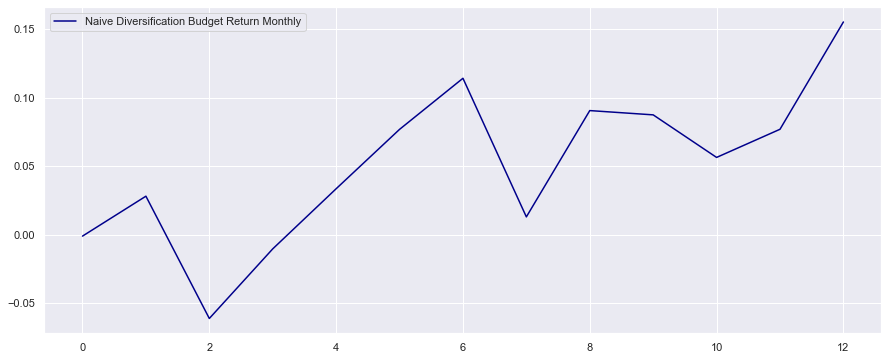

In [17]:
pp.figure(figsize=(15,6))
plt.plot(markowits_budgets_ret [1:14],color='darkblue')
pp.legend(['Naive Diversification Budget Return Monthly'],loc='upper left')

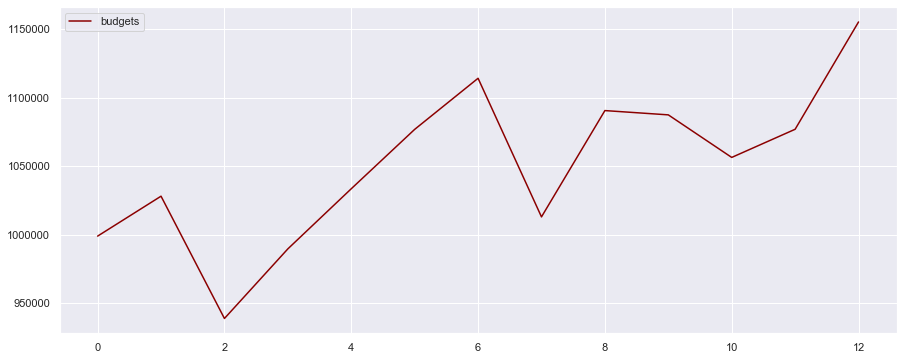

In [18]:
pp.figure(figsize=(15,6))
plt.plot(markowits_budgets[1:251],color='darkred')
pp.legend(['budgets'],loc='upper left')

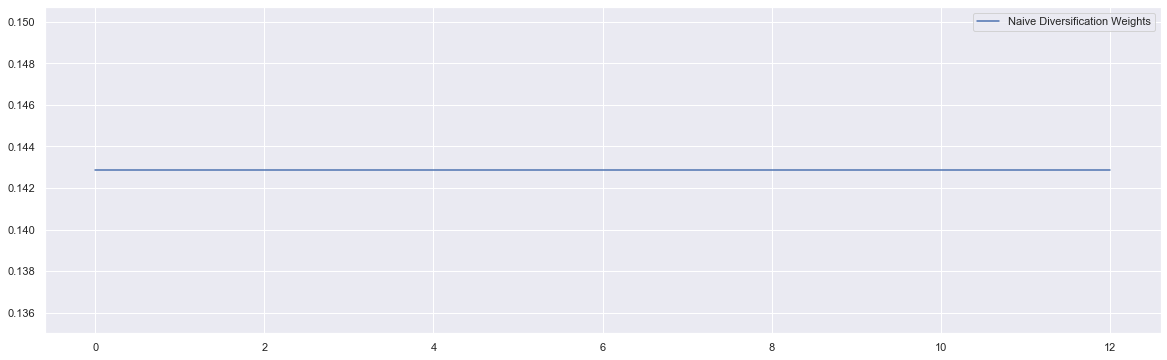

In [19]:
pp.figure(figsize=(20,6))
plt.plot(markowitz_weights[1:20])
pp.legend([ 'Naive Diversification Weights'])

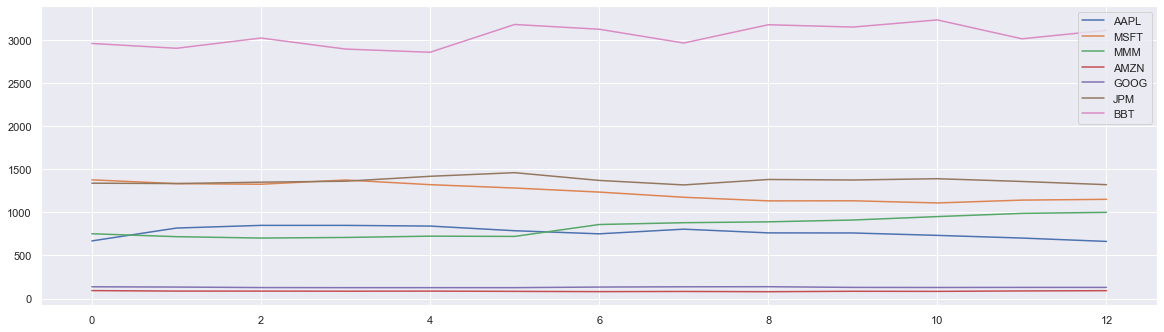

In [21]:
pp.figure(figsize=(20,5.5))
plt.plot(markowits_stock[1:251])
pp.legend([ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

In [22]:
pd.DataFrame(markowits_stock[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

,AAPL,MSFT,MMM,AMZN,GOOG,JPM,BBT
0,669,1377,752,93,137,1338,2958
1,818,1333,718,87,134,1334,2902
2,849,1326,702,87,128,1350,3021
3,849,1375,709,86,127,1361,2893
4,841,1321,724,87,127,1418,2856
5,787,1282,721,84,127,1460,3178
6,751,1235,859,81,134,1370,3123
7,805,1175,880,83,137,1318,2963
8,762,1133,890,80,138,1381,3175
9,761,1134,911,85,130,1375,3148


In [23]:
markowitz_weights

[0,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

In [24]:
#pd.DataFrame(markowitz_weights[1:20], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

In [25]:
pd.DataFrame(markowits_budgets_ret)

,0
0,0.000000
1,-0.000998
2,0.028163
3,-0.061161
4,-0.010323
5,0.033595
6,0.076969
7,0.114296
8,0.013049
9,0.090701


In [26]:
pd.DataFrame(markowits_budgets)

,0
0,0.000000e+00
1,9.990019e+05
2,1.028163e+06
3,9.388390e+05
4,9.896769e+05
5,1.033595e+06
6,1.076969e+06
7,1.114296e+06
8,1.013049e+06
9,1.090701e+06


In [27]:
Markowits_stock = pd.DataFrame(markowits_stock[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])
Markowits_stock.to_excel (r'D:\Naive Diversification_stock.xlsx', index = True, header=True)

In [32]:
Markowitz_weights = pd.DataFrame(markowitz_weights)
Markowitz_weights.to_excel (r'D:\Naive Diversification_weights.xlsx', index = True, header=True)

In [29]:
Markowits_budgets_ret = pd.DataFrame(markowits_budgets_ret)
Markowits_budgets_ret.to_excel (r'D:\Naive Diversification_budgets_ret.xlsx', index = True, header=True)

In [30]:
Markowits_budgets =pd.DataFrame(markowits_budgets)
Markowits_budgets.to_excel (r'D:\Naive Diversification_budgets.xlsx', index = True, header=True)

In [ ]:
print(prices[0,-504])
print(prices[1,-1])
print(prices[2,-504])
print(prices[2,0])
print(prices[2,251])
print(prices[2,-253])
print(len(prices[2,0:504]))
print(len(prices[2,0:503]))
print(len(prices[0,0:7]))
print(prices[0,0:7])





print(prices[:,1:254])
print(prices[:,253])